In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using LinearAlgebra
using Flux, DiffEqFlux
using Plots
using DifferentialEquations: DP5, Tsit5, Vern7, Vern9, BS3
using Random
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)

┌ Info: Precompiling QuantumOptimalControl [e91afccf-c93e-44fd-aa4c-3d3ef13645c0]
└ @ Base loading.jl:1423


false

In [2]:
ω₀ = 2π*5.0
η = -2π*300*1e-3
ωlo = ω₀

31.41592653589793

In [3]:
n_levels = 12
bs = FockBasis(n_levels-1)
a = destroy(bs)
ad = create(bs)
id = identityoperator(bs, bs);

In [4]:
H0 = ω₀*(ad*a + 0.5*id) + (η/12.0)*(a + ad)^4 - η^2 * (a + ad)^6/ω₀/90.0
H1 = 1.0im*(a - ad);

In [5]:
n_neurons = 8
Random.seed!(1)
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, 2))
t0, t1 = 0.0, 4.0

I_guess(t) = @. -2π*exp(-(t-0.5*t1)^2/(0.2*t1)^2)*2.0*(t-0.5*t1) /(0.2*t1)^2
Q_guess(t) = @. -2π*exp(-(t-0.5*t1)^2/(0.2*t1)^2)

tsf32 = Float32(t0):0.001f0:Float32(t1)
Is = Vector{Float32}(I_guess(tsf32))
Qs = Vector{Float32}(Q_guess(tsf32))

ts = Vector{Float64}(tsf32)
function loss(p)
    c = 0.0f0
    for (i,t) in enumerate(tsf32)
        x = ann([t], p)
        c += (x[1] - Is[i])^2
        c += (x[2] - Qs[i])^2
    end
    c
end
res = DiffEqFlux.sciml_train(loss, initial_params(ann), ADAM(0.1f0), maxiters = 500)
θ = Vector{Float64}(res.u);
#θ = Vector{Float64}(initial_params(ann));

In [6]:
coeffs(params, t) = let b = ann([t], params)
                        [b[1]*cos(ωlo*t) + b[2]*sin(ωlo*t)]
                    end
bcs(params) = 0.01*sum(ann([t0], params).^2 + ann([t1], params).^2)
                 
cost = CostFunction((x,y)-> 1.0-real(x'*y), bcs)

CostFunction(var"#1#2"(), bcs)

In [7]:
trans = UnitaryTransform([fockstate(bs, 0), fockstate(bs, 1)], 
                         [[1.0 -1.0im];[-1.0im 1.0]]/√2);

In [8]:
tspan = (t0, t1)
H = Hamiltonian(H0, [H1], coeffs)
prob = QOCProblem(H, trans, tspan, cost);

In [9]:
@time sol = solve(prob, θ, ADAM(0.05), Tsit5(), 1000;
                  abstol=1e-5, reltol=1e-5)

Progress: 100%|█████████████████████████████████████████| Time: 0:24:41
  cost:  0.0022265536145720244


1500.947921 seconds (6.82 G allocations: 675.759 GiB, 25.71% gc time, 2.59% compilation time)


Solution{Float64}([-1.1492633560598182, -0.7739587303820656, -0.3864743271662993, -0.1327017203958054, -1.522895688314545, 0.7821010985552966, -0.9171935830331519, 0.5330254693520766, 0.8369526627621471, 1.416105864260855  …  4.552949328999539, 0.8080256816703648, -1.1529353443353665, -0.20961874325484625, 2.939590682827913, 0.9636450995684294, -1.0673818591835529, 1.9047811995895365, 0.46079310083857894, -0.08073483294106831], [1.1743610855337008, 0.49750084249421156, 0.16603499726725301, 0.1397531658160357, 0.27255952465564465, 0.2728175264690576, 0.21043624586916765, 0.16689155292595537, 0.11913137032046717, 0.07520634638600054  …  0.002247478452096552, 0.0022797507517823834, 0.002290816048704847, 0.0022726339277317487, 0.0022389635973187327, 0.0022335837966162564, 0.002252541500611105, 0.0022561154439407205, 0.0022477863865381087, 0.0022265536145720244])

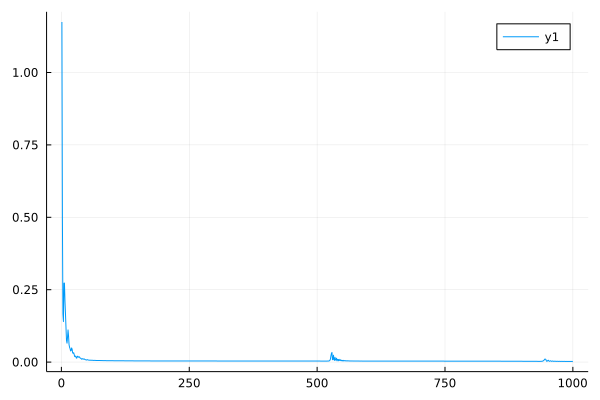

In [10]:
plot(sol.trace)

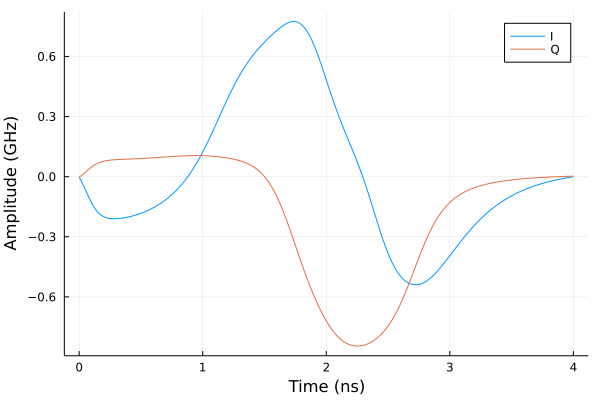

In [11]:
I_wf(t) = ann([t], sol.params)[1]/2π
Q_wf(t) = ann([t], sol.params)[2]/2π

f = plot(ts, I_wf.(ts), label="I")
plot!(f, ts, Q_wf.(ts), label="Q")
xlabel!("Time (ns)")
ylabel!("Amplitude (GHz)")
#savefig(f,"rxpi2_wfs.svg")

In [12]:
tout, psit = schroedinger_dynamic(ts, fockstate(bs, 0), H, sol.params);

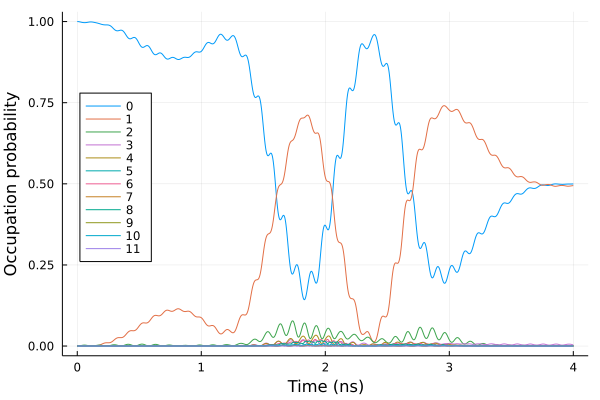

In [13]:
f = plot()
for i in 1:12
    plot!(f, tout, real(expect(dm(fockstate(bs, i-1)), psit)), label=string(i-1), legend=:left)
end
ylabel!(f, "Occupation probability")
xlabel!(f, "Time (ns)")
f
#savefig(f,"rxpi2_probs.svg")